## Imports 


In [3]:
#from datetime import date
#from distutils.command.build import build
#from distutils.log import error
#from pandas import array
#from sys import maxsize
#from random import seed
#from random import randint

from scipy.stats import laplace
from collections import Counter
from scipy import stats
import random as rn
import numpy as np
import pandas as pd
import math
import copy
import matplotlib.pyplot as plt


#import pg
from psycopg2 import sql
from sql.db_conn import conn
import psycopg2 as pg
db = "dbname='taxi2016' user='postgres' host='localhost' password = 'postgres'"


# Introduction
This notebook is divied into two different parts.

    Part 1.
        - Defining the data 
        - Implemenetation of a differential privacy mechanism
        - Functionality for outputting the anonymised data. 
        - The statistical adequasy of the data. 

    Part 2.
        - Setting up the data for an attack 
        - Implementation of rather naive attack 
        - Implementation of a more advanced attack  
        - Understanding what an adveray can achieve 


# Part 1: Implementing Differetial Privacy Mechanism - Counter Algorithm 


## Defining datastructure and creating data 


In [4]:
class Node: 
    def __init__(self, intervalStart, intervalEnd, value):
        self.value = value
        self.left = None
        self.right = None
        self.interval = (intervalStart, intervalEnd)
    
    def printInterval(self):
        print(self.interval, self.value)
    
    def printvalue(self):
        print(self.value)
    
    def getvalue(self):
        return (self.value)

    def getIntervalvalue(self):
        return (self.interval, self.value) 

def dataCreator(T): 
    dataList = []
    for i in range(T): 
        randCount = rn.randint(50,150)
        datapoint = (i, randCount)
        dataList.append(datapoint)
    return dataList

def leafInitializer (data: list): # Creates leafs
    """
    INPUT: dataArray where dataArray[i] = (timeStamp,value) e.g. [(0,1),(1,3),(2,5),(3,1),(4,2),(5,3)] 
    
    OUTPUT: [[S,S],...[T-1,T-1]] 

    Description: Creates T leafs (And leaves only). 
    """
    leafs = []
    for i in range(len(data)): 
        leaf = Node(data[i][0], data[i][0], data[i][1])
        leafs.append(leaf)
    return [leafs]

def createTree (nodesArr: list): #Creates tree
    """
    INPUT: 2D leaf array: [((S,S),V)...((T-1,T-1), V)]] 
        
    OUTPUT: 2D node array -> [[Root Node], [Nodes at level 1], ... [Nodes at level T]] 

    Description: Creates tree of nodes. New tree is traversable thourgh root node. 
                 Used the first array [(0,0), ... (T-1, T-1)], to create a new array corresponding to the next level in the tree. 
                 Thus we continously add a new array corresponding to the level were at. 
                 Steps: 
                    1: 
                        Input = [((0,0),1),((1,1),2)]

                    2:
                        Create new array based on 1. -> nextNodeArr = [((0,1),3)]
                        Then we append input, nextNodearr, getting a 2D arr

                    3:
                        Call recursively on the tail of this new arr
    """
    nodeArrLen = len(nodesArr[-1])
    if nodeArrLen != 1: #Not reached tail 

        nextNodeArr = []                #Array which we append nodes at level i+1
        for i in range(0, nodeArrLen, 2):   #Lenght of tail (The level we are at)
            nodeLeft = nodesArr[-1][i]  #[-1] : Tail - S in -> ((S,T),c)
            nodeRight = nodesArr[-1][i+1]
            newNode = Node(nodeLeft.interval[0], nodeRight.interval[1], nodeLeft.value+nodeRight.value) #Equevilent to union. Here we create the parent
            newNode.left = nodeLeft
            newNode.right = nodeRight
            nextNodeArr.append(newNode) #Appending new node to 
        #Here we do [[NodesAt_i]+[NodesAt_i+1]]     
        newArr = nodesArr
        newArr.append(nextNodeArr)  
        return createTree(newArr)     
        
    else:  #Reached tail 
        nodesArr.reverse()
        return nodesArr

def dataFetch(rows):
    conn = pg.connect(db)
    cur = conn.cursor()
    sql = """
    select concat(TO_CHAR(jan_day, 'fm00'),TO_CHAR(day_hour , 'fm00'),TO_CHAR(hour_min , 'fm00'))::integer as min, count(*) 
    from taxi_pickup_201601
    group by min  -- 44062 rows
    limit {}
    """.format(str(rows))
    try:
        cur.execute(sql)
        data = cur.fetchall()
        timestampData= []
        for i in data:
            timeTuple=(i[0],i[1])
            timestampData.append(timeTuple)
        cur.close()
        return timestampData

    except (Exception, pg.Error) as error:
        print("Error while fetching pick up counts", error)
        cur.close()
        return -1


## Counter Algorithm and General functionality 


In [5]:
####################### Counter Algorithm #################################
def addLapNoise(root: Node, t: int, epsS:float):#Adds noise to every element of tree-structure
    """
    INPUT: 
        Root: root of the three
        t: number of times T
        epsS: epsilon parameter 
        
    OUTPUT: Adding noise to a tree. Does NOT return a new one. 

    Description: Add noise to each node accoring to (1+log2(T))/epsilon
    
    """
    loc = 0
    scale = (((1+math.log2(t))/epsS))   
    noise = np.round(np.random.laplace(loc, scale, 1))
    
    if (root.left or root.right) != None:
        root.value = int(root.value + noise)
        if root.value < 0: 
             root.value = 0
        addLapNoise(root.left, t, epsS) 
        addLapNoise(root.right, t, epsS) 
    else: 
        root.value = int(root.value + noise)
        if root.value < 0: 
            root.value = 0
        return 0

def counterAlgorithm(data: list, epsS: float): 
    """
    INPUT: 
        data: 1D Arr -> Raw data of form [(Time1,value1), ..., (TimeT, ValueT)] 
        eps: Privacy parameter
        
    OUTPUT: Original and Noisy Tree -> [[RootNode], [Nodes at level 2], ... , [Nodes at level T] )

    Description: Adds noise to data, according to Lap (1+log2(T))/epsilon) (Also saves original tree) 
    
    """
    #0. Saving the original Tree. 
    oriLeafs = leafInitializer(data)
    originalTree = (createTree(oriLeafs))

    #1. Initilize Tree / Intervals
    leafs = leafInitializer(data)
    tree = (createTree(leafs))


    #2. Processing (Adding noise via one of the two noise functions 
    t = len(data) 
    root = tree[0][0]
    addLapNoise(root, t, epsS)
    return originalTree, tree


####################### Retrieving Values from a tree #################################
def getIntervalAndValues(tree:list):
    """
    INPUT: Tree of Nodes. [RootNode, root.LeftChild, root.rightChild, root.leftchild.leftchild, ... ] 
        
    OUTPUT: 
        intervalArr = Array of ((S,T),Value)
        valueArr    = Array of values (Starting from the root) 

    Description: Used to fetch intervals+Values, and valuesOnly 
    
    """
    interValsArr = []
    valueArr = []
    lenghtOfTree = len(tree)
    for level in range(lenghtOfTree):
        lenOfLeveli = len(tree[level])
        for node in range(lenOfLeveli):
            valueArr.append((tree[level][node]).getvalue())
            interValsArr.append((tree[level][node]).getIntervalvalue())
    return interValsArr, valueArr

def estimator(t, root): 
    rootS = root.interval[0]
    rootT = root.interval[1]
    
    #root of current tree
    if t == rootT:
        #print(root.printInterval())
        return root.value
    
    #Left part of the current tree
    elif t < rootT/2:
        return estimator(t, root.left)

    #right part of the current tree
    elif t > (rootT)/2: 
        if t > rootS : 
            #print(root.left.printInterval())
            return (root.left.value) + estimator(t, root.right)

        elif t == rootS and t < rootT:
            return estimator(t, root.left)

        else: return 0
    else: return 0

def estimatorST(s, t, root): 
    if s != 0:
        return estimator(t,root) - estimator(s-1,root) 
    else: 
        return estimator(t,root)
 

####################### Printing Functionality #################################
#Taken from: https://www.techiedelight.com/print-two-dimensional-view-binary-tree/ 
def printBinaryTree(root: Node, space: int, height: int):#USE THE ONE BELOW
    # Base case
    if root is None:
        return
     # increase distance between levels
    space += height 
   # print right child first
    printBinaryTree(root.right, space, height)
    print()
    # print the current node after padding with spaces
    for i in range(height, space):
        print(' ', end='')
    print(root.interval, root.value,  end='')
    # print left child
    print()
    printBinaryTree(root.left,  space, height)

def treePrinter(tree: list, size: int):
    """
    INPUT: 
        tree: Tree of form -> [[Root Node], [Nodes at level 1], ... [Nodes at level T]] 
        
    OUTPUT: Printet tree

    Description: Printing binary trees. 
    
    """
    for i in range(len(tree)):   
        toPrint = "        "*(size-i)
        for j in range(len(tree[i])): 
            toPrint = toPrint + "  " + str(tree[i][j].getIntervalvalue())
        print(toPrint+"\n\n")
 

## Testing Counter Algorithm and Data Retrieval Functionality 
In the following cell we create data and run the counter algorithm. We then test retrieve 

In [6]:
#Setting up initial data 
def testRunner():
    T = 2**2
    data = dataCreator(T)
    leaves = leafInitializer(data)
    tree = createTree(leaves)
    print("Initial data: ", data, "\n")

    #Running the counter algorithm on the data
    lowEpsS = 0.5
    highEpsS = 5
    originalTree, noisyTreeLow = counterAlgorithm(data, lowEpsS)
    originalTree, noisyTreeHigh = counterAlgorithm(data, highEpsS)

    #Retriveing original and noisy counts. 
    OGinterval, OGcounts              = getIntervalAndValues(originalTree)
    noisyIntervalLow, noisyCountLow   = getIntervalAndValues(noisyTreeLow)
    noisyIntervalHigh, noisyCountHigh = getIntervalAndValues(noisyTreeHigh)

    OGRoot        = originalTree[0][0] 
    noisyRootHigh = noisyTreeHigh[0][0]
    noisyRootLow  = noisyTreeLow[0][0]

    print("Original Tree")
    treePrinter(originalTree, T)
    print("Noisy Tree Low Eps")
    treePrinter(noisyTreeLow, T)
    print("Noisy Tree High Epsilon ")
    treePrinter(noisyTreeHigh, T)

    #Estimate Counts at time T
    print("Estimate at Time T:", T)
    OGEst        = estimator(T-1, OGRoot)
    noisyEstHigh = estimator(T-1, noisyRootHigh)
    noisyEstLow  = estimator(T-1, noisyRootLow)
    print("OG ", OGEst)
    print("NoisyHigh: ", noisyEstHigh)
    print("noisyLow: ", noisyEstLow, "\n\n")

    #INTERVAL ESTIMATE at all times
    print("Estimate at Intervals")
    for s in range(OGRoot.interval[0],T):
        for t in range(s,T): 
                print("s, t = ", s, t)
                print("OG Estimate: ", estimatorST(s,t,OGRoot))
                print("High Noise Estimate: ", estimatorST(s,t,noisyRootHigh))
                print("Low Noise Estimate: ", estimatorST(s,t,noisyRootLow), "\n")
testRunner()

Initial data:  [(0, 145), (1, 105), (2, 71), (3, 63)] 

Original Tree
                                  ((0, 3), 384)


                          ((0, 1), 250)  ((2, 3), 134)


                  ((0, 0), 145)  ((1, 1), 105)  ((2, 2), 71)  ((3, 3), 63)


Noisy Tree Low Eps
                                  ((0, 3), 387)


                          ((0, 1), 246)  ((2, 3), 133)


                  ((0, 0), 145)  ((1, 1), 102)  ((2, 2), 72)  ((3, 3), 76)


Noisy Tree High Epsilon 
                                  ((0, 3), 384)


                          ((0, 1), 251)  ((2, 3), 135)


                  ((0, 0), 147)  ((1, 1), 105)  ((2, 2), 72)  ((3, 3), 64)


Estimate at Time T: 4
OG  384
NoisyHigh:  384
noisyLow:  387 


Estimate at Intervals
s, t =  0 0
OG Estimate:  145
High Noise Estimate:  147
Low Noise Estimate:  145 

s, t =  0 1
OG Estimate:  250
High Noise Estimate:  251
Low Noise Estimate:  246 

s, t =  0 2
OG Estimate:  321
High Noise Estimate:  323
Low Noise Estimate:  318 


## Testing Statistical Edequacy

#### Plotting Laplace Noisy at different epsilon Values

In [7]:
def expectedErrors(eps, T, interval): 
    lapB = laplace.cdf(interval, 0, ((1+math.log2(T))/eps))
    lapA = laplace.cdf(0-interval, 0, ((1+math.log2(T))/eps))
    prop = lapB-lapA
    return prop

def CalculateCDFOnIntervals(epsValues, T): 
    for eps in epsValues: 
        print("\nEps", eps)
        for inter in intervals: 
            print("Interval", 0-inter, inter)
            print(expectedErrors(eps, T, inter))

#Plot noisy Functions 
def plotNoise(epsValues, treeSizes): 
    for eps in epsValues:
        for t in treeSizes:
            x = np.linspace(-25,25, num=1000)
            loc = 0
            scale = (((1+math.log2(t))/eps)) 
            yValues = stats.laplace.pdf(x, loc = 0, scale = scale)
            
            a = np.round(np.random.laplace(loc, scale, 100))
            count = 0 
            for value in a: 
                if value > -0.5 and value < 0.5:
                    count = count+1
            #print("eps", eps, "pr[X = 0] =", count/100)
            #xFullValues = [-5,-4,-3,-2,-1,0,1,2,3,4,5]
            plt.plot(x, yValues/100, label = ("Treesize:"+str(t)+" Eps: "+str(eps)))
            plt.legend()
    plt.title("Laplace Distributions at different Epsilon Values")
    plt.show()



Eps 0.1
Interval -1 1
0.011049610706077628
Interval -5 5
0.05404053109323459
Interval -10 10
0.10516068318563021
Interval -20 20
0.19926259708319188

Eps 0.5
Interval -1 1
0.05404053109323459
Interval -5 5
0.24253487160303355
Interval -10 10
0.4262465792625672
Interval -20 20
0.6708070121920944

Eps 1
Interval -1 1
0.10516068318563021
Interval -5 5
0.4262465792625672
Interval -10 10
0.6708070121920944
Interval -20 20
0.8916319767781042

Eps 2
Interval -1 1
0.19926259708319188
Interval -5 5
0.6708070121920944
Interval -10 10
0.8916319767781042
Interval -20 20
0.9882563715429786

Eps 5
Interval -1 1
0.4262465792625672
Interval -5 5
0.9378234759778836
Interval -10 10
0.9961340798605272
Interval -20 20
0.9999850546614752


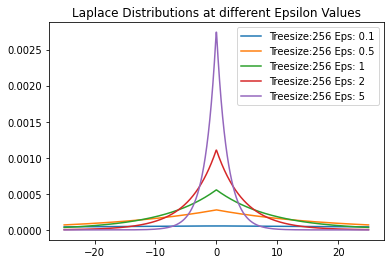

In [8]:
maxTreeSize = 7
epsValues = [0.1, 0.5, 1,  2, 5]
intervals = [1, 5, 10, 20]
treeSizes = [2**8]
CalculateCDFOnIntervals(epsValues, treeSizes[0] )
plotNoise(epsValues, treeSizes)

### Finding the averager number of nodes that does not change at different epsilon values 

In [9]:
def changedNodes(T, eps):
    data = dataCreator(T)
    originalTree, noisyTree   = counterAlgorithm(data, eps)
    OGInterval, OGvalue       = getIntervalAndValues(originalTree)
    NoisyInterval, Noisyvalue = getIntervalAndValues(noisyTree)

    diffInPos = np.count_nonzero(np.array(OGvalue)==np.array(Noisyvalue))
    return diffInPos

def meanChangedNodes(loopSize, t, epsVal): 
    meanDist = 0 
    for i in range(loopSize):
        meanDist = meanDist + changedNodes(t, epsVal)
    meanDist = (meanDist-t)/loopSize
    meanChangedPercent = meanDist/(t*2-1)
    #print("eps:", epsVal, "ChangedNodes:", round(meanDist,2), "Percent", round(meanDistPerNode,2))
    return meanChangedPercent
            
def plotMeanChangedNodes(loopSize, minT, maxT, epsVals): 
    tValues = [2**i for i in range(minT, maxT+1, 1)]
    for t in tValues:
        #print("t:", t, "nodes:", t*2-1)
        arr = []
        for eps in epsVals: 
            meanDist = meanChangedNodes(loopSize, t, eps)
            arr.append(meanDist)
        
        #plt.legend(label = "No. Nodes:"+str(t*2))
        plt.plot(epsVals, arr,label='t='+str(t))
        plt.legend()
    plt.xlabel("Epsilon")
    plt.ylabel("Pct. of nodes that remain unchanged")
    plt.show()
        #plt.legend(label=t)

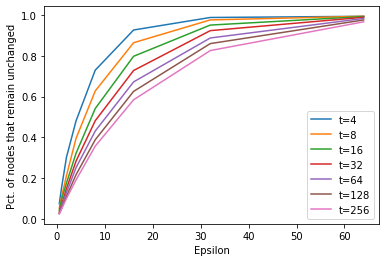

In [10]:
#Setup Variables 
loopSize = 100
minT = 2
maxT = 8
epsValues = [0.5, 1, 2, 4, 8, 16, 32, 64]

#Find  
plotMeanChangedNodes(loopSize, minT, maxT, epsValues)

# Part 2: Attack Continual Observation 

#### Generel Functionality

In [11]:
######## Helper functions for traceAttLeaves #########
#Remove one from the last leaf.
def removeOneFromTLeaves(OGLeafs):
    OGLeafs[-1] = OGLeafs[-1]-1 #Last count-1
    return OGLeafs

#Remove one from the last leaf, and all of its parents.
def removeOneFromTFull(OGData, T): 
    knownData = np.array(OGData)
    knownData[0] = knownData[0]-1
    #Removing one person from the tree (From the last leaf)
    for i in range(1, int(math.log2(T))): 
        removeAtNode = 2*(i**2-i+1)
        knownData[removeAtNode] = knownData[removeAtNode]-1 #Last count-1
    knownData[-1] = knownData[-1]-1
    return knownData
    
######## Helper functions for traceAttFull #########
class simpleNode: 
    def __init__(self, value):
        self.value = value
        self.left = None
        self.right = None
        self.parent = None
    def print(self):
        print(self.value)

#Add one to a node, and all of its parents
def addOneToTree(node):
    node.value = node.value+1
    if node.parent != None: 
        return addOneToTree(node.parent)
    else: 
        return 

#Remove one from a node, and all of its parents
def RemoveOneFromTree(node):
    node.value = node.value-1
    if node.parent != None: 
        return RemoveOneFromTree(node.parent)
    else:
        return 

#Retrieve values from a FullTree.
def getValues(tree):
    values = []
    for node in tree:
        values.append(node.value)
    return np.array(values)
######################################################

#### Probability Calculation of Noisy Vector

In [12]:
#Calculate the probability of drawing noise vector 
def propCalc(noise, T, loc,  eps):
    lapB = np.array(laplace.cdf(noise+0.5, loc, ((1+math.log2(T))/eps)), dtype=np.float128)
    lapA = np.array(laplace.cdf(noise-0.5, loc, ((1+math.log2(T))/eps)), dtype=np.float128)
    prop = np.array(lapB-lapA, dtype=np.float128)
    
    #Removing -inf and NAN values: 
    prop = [item for item in prop if item > 0.0000000001]
    prop = np.nan_to_num(prop, copy=False, nan=0.00000000001, posinf=0.00000000001, neginf=0.00000000001)

    logProp = np.log(prop, dtype=np.float128)
    logPropSum =  np.sum(logProp, dtype=np.float128)
    
    return logPropSum


#### Attack on Leaves Only - Funtionality

In [13]:
def traceAttLeaves(knownData, noisyData, loc, eps, T): 
    #Initilizing posteriors 
    posteriors = np.array([-1.0]*len(knownData), dtype=np.float128)
    
    #Finding pure noisy 
    pureNoise = noisyData-knownData
    
    for i in range(len(pureNoise)): 
        #Adding one to current universe 
        pureNoise[i] = pureNoise[i]-1
        propSum = propCalc(pureNoise, T, loc,  eps)
        posteriors[i] = propSum
        #Resetting noise
        pureNoise[i] = pureNoise[i]+1   
    
    #Reverse Log
    #posteriors = np.nan_to_num(posteriors, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    posteriors = np.exp((posteriors), dtype=np.float128)
    posteriors = np.divide(posteriors, np.sum(posteriors))
   
    return posteriors

#### Attack on Full Tree - Functionality

In [14]:
def traceAttFull(knownData, noisyData, loc, eps, T): 
    noisyData = np.array(noisyData)
    #Getting only noisy
    pureNoise = noisyData-knownData
    
    treeReversed = [] #Reverse tree of nodes )
    for i in range(len(pureNoise)):
        node = simpleNode(pureNoise[i])
        treeReversed.append(node)
    
    treeReversed.reverse()
    
    #Setting parents 
    for i in range(0, int(T-1)):
        leftIndex = 2*i
        rightIndex = 2*i+1
        treeReversed[leftIndex].parent = treeReversed[T+i]
        treeReversed[rightIndex].parent = treeReversed[T+i]
    
    treeReversed.reverse()
    
    #Calculating properbilities 
    posteriors = np.array([-1.0]*T, dtype=np.float128)
    for i in range(T): 
        #Adding one throughout the tree
        RemoveOneFromTree(treeReversed[T-1+i])
        #Calculate prob
        noiseValues = getValues(treeReversed)
        posteriors[i] = propCalc(noiseValues, T, loc,  eps)  
        #Resetting the tree
        addOneToTree(treeReversed[T-1+i])
    
    #Reverse Log
    posteriors = np.exp((posteriors))
    posteriors = posteriors/np.sum(posteriors)
    return posteriors


#### Attack Preparation - Functionality
The following cell contains two functions.
prepAttackLeaves() simulates one attack on the leaves and returns the posteriors 
prepAttackFull() simulates one attack on the full tree and returns the posteriors



In [15]:
def prepAttackLeaves(T, eps, printBool):    
    data = dataCreator(T)
    originalTree, noisyTree   = counterAlgorithm(data, eps)
    OGInterval, OGvalue       = getIntervalAndValues(originalTree)
    NoisyInterval, Noisyvalue = getIntervalAndValues(noisyTree)

    #Retrieving Leaves
    Noisyvalue = np.array(Noisyvalue[T-1:])
    knownData = removeOneFromTLeaves(OGvalue)
    knownData = np.array(OGvalue[T-1:])

    if (printBool): 
        print("Known", knownData)
        print("noisy", Noisyvalue)
        print("Diff:", Noisyvalue-knownData)
        print("DiffSum", sum(Noisyvalue-knownData))


    posteriors = traceAttLeaves(knownData, Noisyvalue, 0, eps, T)
    return posteriors

def prepAttackFull(T, eps, printBool):    
    data = dataCreator(T)
    originalTree, noisyTree   = counterAlgorithm(data, eps)
    OGInterval, OGvalue       = getIntervalAndValues(originalTree)
    NoisyInterval, Noisyvalue = getIntervalAndValues(noisyTree)
    
    knownData = removeOneFromTFull(OGvalue, T)
    if (printBool): 
        print("Known:", knownData)
        print("noisy:", Noisyvalue)
        print("Diff:", Noisyvalue-knownData)
        print("DiffSum", sum(Noisyvalue-knownData))
    
    posteriors = traceAttFull(knownData, Noisyvalue, 0, eps, T)
    return posteriors


### Testing

#### Showcasing Attacks 

In [16]:
def runner():
    'Specified Values Example'
    print("##################### Attack on specified values #########################")
    known = np.array([19,7,12,0,7,10,2])
    noisy = np.array([20,7,13,0,7,10,3])
    eps = 7.88
    T = 4
    print("t:", T, "Eps:", eps, "Post:")
    print("Leaves:", traceAttLeaves(known[T-1:], noisy[T-1:], 0, eps, T ))
    print("Full:", traceAttFull(known, noisy, 0, eps,4 ))
    print("\n")

    print("##################### Attack on specified values #########################")
    known = np.array([19,    7,12,    0,7,9,2])
    noisy = np.array([20,    7,13,    0,7,10,3])
    eps = 7.88
    T = 4
    print("t:", T, "Eps:", eps, "Post:")
    print("Leaves:", traceAttLeaves(known[T-1:], noisy[T-1:], 0, eps, T ))
    print("Full:", traceAttFull(known, noisy, 0, eps,4 ))
    print("\n")


    'Showcase Attack Leaves'
    print("#####################ShowCase Attack #########################")
    T = 2**2
    eps = 0.5
    LeavesShowCasePost = prepAttackLeaves(T, eps, printBool=False)
    FullShowCasePost = prepAttackFull(T, eps, printBool=False)
    print("t:", T, "Eps:", eps, "Post:")
    print("Leaves:", LeavesShowCasePost)
    print("Full", FullShowCasePost)
    print("\n")

    T = 2**2
    eps = 1
    LeavesShowCasePost = prepAttackLeaves(T, eps, printBool=False)
    FullShowCasePost = prepAttackFull(T, eps, printBool=False)
    print("t:", T, "Eps:", eps, "Post:")
    print("Leaves:", LeavesShowCasePost)
    print("Full", FullShowCasePost)
    print("\n")


    T = 2**2
    eps = 5
    LeavesShowCasePost = prepAttackLeaves(T, eps, printBool=False)
    FullShowCasePost = prepAttackFull(T, eps, printBool=False)
    print("t:", T, "Eps:", eps, "Post:")
    print("Leaves:", LeavesShowCasePost)
    print("Full", FullShowCasePost)
    print("\n")

    T = 2**2
    eps = 20
    LeavesShowCasePost = prepAttackLeaves(T, eps, printBool=False)
    FullShowCasePost = prepAttackFull(T, eps, printBool=False)
    print("t:", T, "Eps:", eps, "Post:")
    print("Leaves:", LeavesShowCasePost)
    print("Full", FullShowCasePost)
    print("\n")

runner()


##################### Attack on specified values #########################
t: 4 Eps: 7.88 Post:
Leaves: [0.02677319 0.02677319 0.02677319 0.91968044]
Full: [8.22146424e-04 8.22146424e-04 2.82413884e-02 9.70114319e-01]


##################### Attack on specified values #########################
t: 4 Eps: 7.88 Post:
Leaves: [0.01414395 0.01414395 0.48585605 0.48585605]
Full: [4.23378076e-04 4.23378076e-04 4.99576622e-01 4.99576622e-01]


#####################ShowCase Attack #########################
t: 4 Eps: 0.5 Post:
Leaves: [0.2912851 0.2087149 0.2912851 0.2087149]
Full [0.2690681  0.19279571 0.2690681  0.2690681 ]


t: 4 Eps: 1 Post:
Leaves: [0.17948181 0.32051819 0.32051819 0.17948181]
Full [0.28462319 0.28462319 0.28462319 0.14613042]


t: 4 Eps: 5 Post:
Leaves: [0.05004043 0.05004043 0.05004043 0.84987871]
Full [0.26683261 0.26683261 0.02593077 0.44040401]


t: 4 Eps: 20 Post:
Leaves: [3.40914290e-04 3.40914290e-04 3.40914290e-04 9.98977257e-01]
Full [1.16420892e-07 1.16420892e-07

## Examining The Correlation Between Epsilon and Possibility for Successfull Attacks 

### Determining average number of successfull attacks for different epsilon-values and T

#### Functionality 


In [17]:
##########LEGACY#########
def TestLeavesOnly (loopSize, maxT): 
    bestGuess = 0 
    #maxTreeSize = 2*maxT
    tSizeArrLow = []
    tSizeArrHigh = []
    for i in range(maxT):
        epsArrLow = []
        epsArrHigh = []
        T = 2**i
        eps = 0.1
        prGuessCorrect = 0
        while (prGuessCorrect < 0.60 and eps < 150): 
            correctGuesses = 0 
            for i in range(loopSize): 
                posteriors, posteriorsFull = prepAttackLeaves(T, eps)
                posteriorsT = np.flip(posteriors)
                
                #LEAVES ONLY
                winner = np.argwhere(posteriorsT == np.amax(posteriorsT))
                pick = rn.choice(winner)
                if (pick == 0):
                    correctGuesses = correctGuesses + 1
            prGuessCorrect = correctGuesses/loopSize
            if eps < 1:
                epsArrLow.append((eps, prGuessCorrect))
                eps = np.round(eps+0.1, 5)
            else:
                epsArrHigh.append((eps, prGuessCorrect))
                eps = np.round(eps*1.2, 5)
                
        tSizeArrLow.append(epsArrLow)
        tSizeArrHigh.append(epsArrHigh)
        
    tSizeArrLow = [x for x in tSizeArrLow if x]
    tSizeArrHigh = [x for x in tSizeArrHigh if x]
    return  tSizeArrLow, tSizeArrHigh

def TestFullTree(loopSize, maxTreeSize): 
    bestGuess = 0 
    tSizeArrLow = []
    tSizeArrHigh = []
    for i in range(0, maxTreeSize):
        epsArrLow = []
        epsArrHigh = []
        T = 2**i
        print("Prior: ", 1/T)
        eps = 0.1
        prGuessCorrect = 0
        while (prGuessCorrect < 0.90 and eps < 150): 
            correctGuesses = 0 
            for i in range(loopSize): 
                posteriors, posteriorsFull = prepAttackFull(T, eps)
                posteriorsT = np.flip(posteriorsFull)
                winner = np.argwhere(posteriorsT == np.amax(posteriorsT))
                np.array(winner).flatten() 
                if winner.size != 0:
                    pick = rn.choice(winner)
                    if (pick == 0):
                        correctGuesses = correctGuesses + 1

            prGuessCorrect = correctGuesses/loopSize
            print("t: ", T, "eps ", eps, "PrBestGuess ", prGuessCorrect)

            if eps < 5:
                epsArrLow.append((eps, prGuessCorrect))
                eps = np.round(eps*2, 2)
            else:
                epsArrHigh.append((eps, prGuessCorrect))
                eps = np.round(eps*2, 2)

        tSizeArrLow.append(epsArrLow)
        tSizeArrHigh.append(epsArrHigh)
    tSizeArrLow = [x for x in tSizeArrLow if x]
    tSizeArrHigh = [x for x in tSizeArrHigh if x]
    return tSizeArrLow, tSizeArrHigh

def plotBestGuess(arr):
    for i in range(0,len(arr)):
        TArr = arr[i] 
        eps, prop = (zip(*TArr))
        plt.scatter(eps, prop, label=('T='+str(2**i)))
        plt.xlabel('Epsilon-Value')
        plt.ylabel('Average Max Probability')
        plt.legend()
    plt.show()
    return 1
##############################

### NEW ###

## Helper Function For simpleTest##
def determineGuess(post):
    posteriorsT = np.flip(post)
    winner = np.argwhere(posteriorsT == np.amax(posteriorsT))
    winner = np.array(winner).flatten() 
    winner = rn.choice(winner)
    if (winner == 0):
        return True
    
    else: 
        return False

def simpleTest(loopSize, T, minEps, maxEps, epsIncrease):
    eps = minEps
    leafsOnly = []
    fullTree = []
    while (eps < maxEps): 
        correctGuessesLeafs = 0
        correctGuessesFullTree = 0

        for i in range(loopSize): 
            posteriors = prepAttackLeaves(T, eps, printBool=False)
            posteriorsFull = prepAttackFull(T, eps, printBool=False)
            
            if determineGuess(posteriors): 
                correctGuessesLeafs = correctGuessesLeafs + 1

            if determineGuess(posteriorsFull): 
                correctGuessesFullTree = correctGuessesFullTree + 1
        
        percentGuessCorrectLeafs = correctGuessesLeafs/loopSize
        percentGuessCorrectFull = correctGuessesFullTree/loopSize

        leafsOnly.append((eps, percentGuessCorrectLeafs))
        fullTree.append((eps, percentGuessCorrectFull))
        eps = eps+epsIncrease

    return leafsOnly, fullTree

#Plotting Function 
def plotBestGuessSimple(arr, T, title, pltFig): 
    eps, prop = (zip(*arr))
    pltFig.scatter(eps, prop, label=('T=', T))
    pltFig.legend()
    





#### Plotting 

[8, 16, 32, 64, 128, 256]


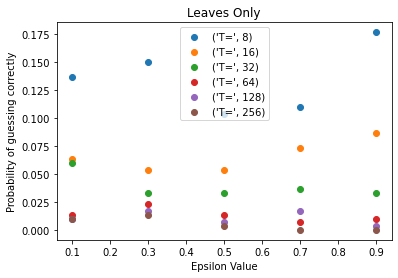

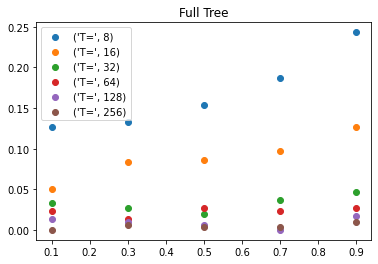

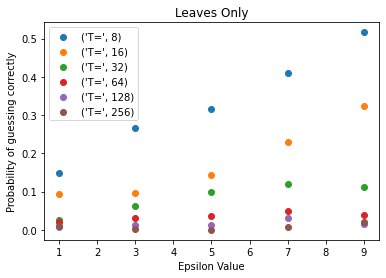

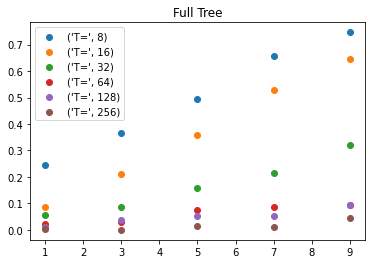

In [18]:
def runner():
    loopSize = 300
    minT = 3
    maxT = 8
    tValues = [2**i for i in range(minT, maxT+1)]
    print(tValues)
    minMaxInc = [(0.1, 1., 0.2), (1, 10., 2),  (10., 120., 5.)]

    for epsVal in minMaxInc: 
        fig1 = plt.figure()
        fig2 = plt.figure()
        
        subplot1=fig1.add_subplot(1,1,1, label = "Leaves")
        subplot1.set_title("Leaves Only")
        subplot1.set_xlabel('Epsilon Value')
        subplot1.set_ylabel('Probability of guessing correctly')


        subplot2=fig2.add_subplot(1,1,1, label = "Full Tree")
        subplot2.set_title("Full Tree")
        subplot1.set_xlabel('Epsilon Value')
        subplot1.set_ylabel('Probability of guessing correctly')
        
        for t in tValues:
            arrLeafs, arrFull = simpleTest(loopSize, t, epsVal[0], epsVal[1], epsVal[2])
            plotBestGuessSimple(arrLeafs, t, "Leafs Only", subplot1)  
            plotBestGuessSimple(arrFull, t, "Full Tree", subplot2)
        plt.show()

runner()



### Determining the average distance to the correct answer 

#### Functionality

In [ ]:
def sharedEdges(c, g, low, high): 
    middleValue = (low+high)/2
    if (c == g): 
        return int(math.log2(high+1)) 

    if c > middleValue and g > middleValue:
        newLow = math.ceil(middleValue)
        return 1+LevelsBetween(c,g, newLow, high)
    
    if c < middleValue and g < middleValue :
        newHigh = math.floor(middleValue)
        return 1+LevelsBetween(c,g, low, newHigh)
    
    else: 
        return 0
       
def diffToCorrect(loopSize, epsValues, t):
    #print("Naive Correct Levels:", (t-1)/t, "Percent:", (t-1)/t/math.log2(t))
    returnArr = []
    for eps in epsValues: 
        averageCorrectSteps = 0 
        for j in range(loopSize):
            #Calculating Posteriors 
            posteriorsFull = prepAttackFull(t, eps, printBool=False)
            
            #Flipping Array to put missing Count at index 0 
            posteriorsT = np.flip(posteriorsFull)

            #Finding Index of maximum probability 
            winner = np.argwhere(posteriorsT == np.amax(posteriorsT))
            np.array(winner).flatten()

            #Checking whether more than one value share maximum 
            if winner.size != 0:
                    winner = rn.choice(winner)
            averageCorrectSteps = averageCorrectSteps+sharedEdges(0, winner, 0, t-1)
            
        averageCorrectSteps = averageCorrectSteps/loopSize
        nodesLeft = t/(2**averageCorrectSteps)
        #print("eps: ", eps,  "CP", round(AverageDistFromCorrect,2))
        returnArr.append(averageCorrectSteps)
    return returnArr


#### Plotting


tValue:  16 levels: 4.0
[1.025, 0.97, 1.135, 1.195, 1.255, 2.4, 3.32, 3.725, 3.91, 3.985]


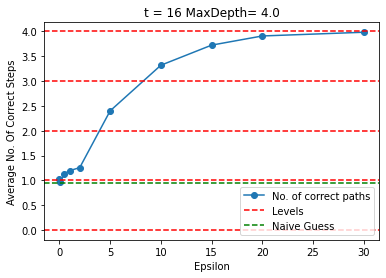

tValue:  32 levels: 5.0
[0.89, 0.9, 1.005, 1.29, 1.445, 1.77, 2.855, 3.615, 4.105, 4.645]


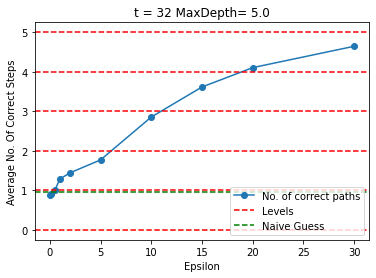

tValue:  64 levels: 6.0
[1.09, 1.09, 1.125, 1.205, 1.2, 1.7, 2.66, 3.145, 3.975, 4.825]


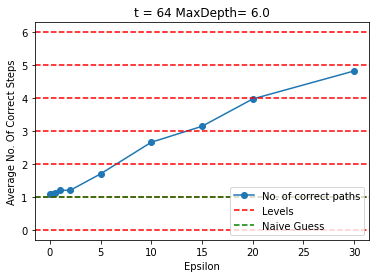

tValue:  128 levels: 7.0
[0.97, 1.01, 1.09, 0.95, 0.88, 1.84, 2.715, 3.675, 4.26, 5.74]


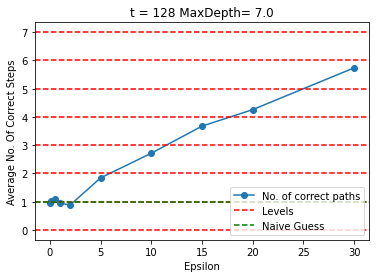

tValue:  256 levels: 8.0
[1.185, 1.2, 1.13, 1.165, 1.16, 1.535, 2.48, 2.79, 3.53, 5.19]


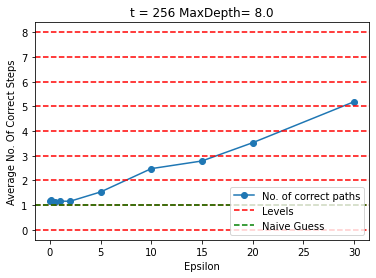

In [ ]:
loopSize = 200
minT = 4
maxT = 8
tValues = [2**i for i in range(minT, maxT+1)]
epsValues = [0.001, 0.1, 0.5, 1, 2, 5, 10, 15, 20, 30]
for tVal in tValues:
    print("tValue: ", tVal, "levels:", math.log2(tVal))
    aveCorrectlevels = diffToCorrect(loopSize, epsValues, tVal)
    print(aveCorrectlevels)
    naive = (tVal-1)/tVal
    
    plt.plot(epsValues, aveCorrectlevels, label = "No. of correct paths", marker='o')
    levels = [i for i in range(0, int(math.log2(tVal)))]
    for line in levels: 
        plt.axhline(line, color='r',  linestyle='--')
    plt.axhline(math.log2(tVal), color='r',  linestyle='--', label = "Levels")
    #Naive guess
    plt.axhline(naive, color='g', linestyle='--', label = "Naive Guess")
    plt.xlabel("Epsilon")
    plt.ylabel("Average No. Of Correct Steps")
    plt.title("t = "+str(tVal)+" MaxDepth= "+str(math.log2(tVal)))
    plt.legend(loc=4)
    plt.show()

[256]


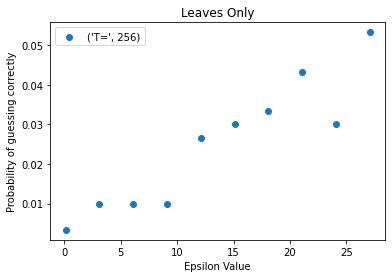

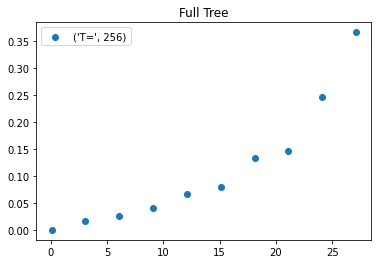

In [ ]:
loopSize = 300
minT = 8
maxT = 8
tValues = [2**i for i in range(minT, maxT+1)]
print(tValues)
minMaxInc = [(0.1, 30., 3)]

for epsVal in minMaxInc: 
    fig1 = plt.figure()
    fig2 = plt.figure()
    
    subplot1=fig1.add_subplot(1,1,1, label = "Leaves")
    subplot1.set_title("Leaves Only")
    subplot1.set_xlabel('Epsilon Value')
    subplot1.set_ylabel('Probability of guessing correctly')


    subplot2=fig2.add_subplot(1,1,1, label = "Full Tree")
    subplot2.set_title("Full Tree")
    subplot1.set_xlabel('Epsilon Value')
    subplot1.set_ylabel('Probability of guessing correctly')
    
    for t in tValues:
        arrLeafs, arrFull = simpleTest(loopSize, t, epsVal[0], epsVal[1], epsVal[2])
        plotBestGuessSimple(arrLeafs, t, "Leafs Only", subplot1)  
        plotBestGuessSimple(arrFull, t, "Full Tree", subplot2)
    plt.show()

# LEGACY CODE 

In [ ]:
# def QueryErrorTesting(k, epsS): 
#     """
#     INPUT: 
#         k = T. The amount of leaves in the largest tree. If k = 8, we make loop through T = 1, ... T 
        
#     OUTPUT: 

#     Description: 
#         For i = 1, ... T:
#             1. Make 500 trees 
#             2. Make i estimate queries 
#             3. Find the greatest diff in query from OG Tree, and noisy Tree. 
            
#     """
#     maxValues = []
#     maxBound = []
#     tightBound = []
#     iValues = []

#     for T in range(k):
#         treeSizeI = 2**T
#         iValues.append(treeSizeI)
#         meanErrorT = []
        
#         #Loop through 1000 iterations, creating new trees each time
#         for j in range(100):
#             currentData = dataCreator(treeSizeI)
#             originalTree, noisyTree = counterAlgorithm(currentData, epsS)
#             OGRoot = originalTree[0][0]
#             NoisyRoot = noisyTree[0][0]

#             #Call i queries and save the greatets difference between OG and Noisy
#             maxQueryDiff = 0                 
#             for s in range(T): 
#                 OGEstimate = estimator(s, OGRoot)
#                 noisyEstimate = estimator(s, NoisyRoot)
#                 absQueryDiff = abs(OGEstimate-noisyEstimate)
#                 if maxQueryDiff < absQueryDiff: maxQueryDiff = absQueryDiff

#             meanErrorT.append(maxQueryDiff)
#         maxValues.append(np.mean(meanErrorT))
#         #Finding the mean of the max-value array. Saving 
#         maxBound.append((math.log2(treeSizeI))**5/3) #Maximum expected error for tree of size i
#         tightBound.append((math.log2(treeSizeI))**3/2) #Tightly concentrated for tree of size i


#     #Plotting
#     plt.plot(iValues, maxValues)
#     #plt.plot(iValues, maxBound)
#     plt.plot(iValues, tightBound)
#     plt.plot(iValues, maxValues, "bo")
#     #plt.plot(iValues, maxBound, "yo")
#     plt.plot(iValues, tightBound, "go")
#     plt.xlabel("T (Leaves)")
#     plt.ylabel("Max Error")
#     plt.title(("Epsilon =", epsS))
#     plt.legend(['Test Values', 'Tight Bound = log2(T)^5/3'])
#     saveFile = "ErrorPlots/eps_"+str(epsS)+".png"
#     plt.savefig(saveFile, dpi = 300)
#     #plt.clf()
#     plt.show()

#     print("tValues", iValues)
#     print("Test Max Error at T    ", maxValues)
#     print("Tigh Around       ",tightBound)
#     print("Max Expected Error" , maxBound)
#     print("\n\n")
# k = 12
# lowEpsS = 0.1
# highEpsS = 5
# QueryErrorTesting(k, lowEpsS)
# QueryErrorTesting(k, highEpsS)

In [ ]:
# def createTestData(eps, T): 
#     data = dataCreator(T)
#     originalTree, noisyTree = counterAlgorithm(data, eps)
#     OGInterval, OGvalue       = getIntervalAndValues(originalTree)
#     NoisyInterval, Noisyvalue = getIntervalAndValues(noisyTree)
#     return OGvalue, Noisyvalue

# def meanOfData(eps, T, loopSize): 
#     meanOG = [0]*(T*2-1)
#     meanNoisy = [0]*(T*2-1)
#     for i in range(loopSize):
#         og, noisy = createTestData(eps,T)
#         meanOG    = np.add(meanOG, og)
#         meanNoisy = np.add(meanNoisy, noisy)
#         #print(meanOG, meanNoisy)

#     meanOG    = np.divide(meanOG, loopSize)
#     meanNoisy = np.divide(meanNoisy,loopSize)
#     return meanOG, meanNoisy
              
# def euclidDist(OG, Noisy):
#     return 1

# def mean(OG, noisy): 
#     return np.abs(np.mean(OG)-np.mean(noisy))

# def median(OG,noisy): 
#     return np.abs(np.median(OG)-np.median(noisy))

# def SD(OG, noisy):
#     return np.abs(np.std(OG)-np.std(noisy))

# def variance(OG, noisy): 
#     return np.abs(np.var(OG)-np.var(noisy))

# def all(maxT, epsArr, loopSize): 
#     for t in range(1, maxT): 
#         for epsVal in epsArr:
#             print("t: ", 2**t, " eps:", epsVal)
#             og, noisy = meanOfData(epsVal, 2**t, loopSize)
            
#             m    = mean(og, noisy)
#             medi = median(og, noisy)
#             sd   = SD(og, noisy)
#             var  = variance(og, noisy)

#             #print("OG", og)
#             #print("Noisy", noisy)
#             print("diff", og-noisy)
#             print("Mean: ", m)
#             print("Median: ", medi )
#             print("Standard Deviation ", sd)
#             print("Variance:", var )
#             print("")    
# maxT   = 7
# epsArr = [0.1, 0.5, 1.0, 5.0, 10.0, 25.0]
# loopSize = 500
# all(maxT,epsArr, loopSize)

In [ ]:
# def discretePDF(posteriors, title): 
#     """
#     From: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_discrete.html
#     INPUT: 
        
#     OUTPUT: 

#     Description: 
    
#     """
#     xk = np.arange(len(posteriors), dtype=int)
#     pk = posteriors
#     custm = stats.rv_discrete(name='custm', values=(xk, pk))
    
#     fig, ax = plt.subplots(1, 1)
#     ax.plot(xk, custm.pmf(xk), 'ro', ms=12, mec='r')
#     ax.vlines(xk, 0, custm.pmf(xk), colors='r', lw=4)
#     plt.title(title+"Prop that person is found at time X")
#     plt.xlabel("Leafes")
#     plt.ylabel("Probability")
#     #saveFile = "Plots/"+str(title)+"_discretePDF.png"
#     #plt.savefig(saveFile, dpi = 300)
#     plt.show()

# def discreteCDF(posteriors, title): 
#     cdf = np.cumsum(posteriors)
#     xk = np.arange(len(posteriors))
#     plt.plot(xk, cdf, label="CDF")
#     plt.title(title+" Discrete CDF Prop that person is found at time X")
#     plt.xlabel("Leafes (t)")
#     plt.ylabel("Probability")
#     #saveFile = "Plots/"+str(title)+"_discreteCDF.png"
#     #plt.savefig(saveFile, dpi = 300)
#     plt.show()

# #discretePDF(scaledPosteriors, "Scaled Attack")
# #discreteCDF(scaledPosteriors, "Scaled Attack")


In [ ]:
# #######################LEGACY########################
# def traceAttOLD(OGData, noisyData, loc, eps, T):
#     """
#     INPUT: 
        
#     OUTPUT: 

#     Description: 
    
#     """
    
#     knownData = OGData[T-1:]
#     #print("OGData:    ", knownData)
#     noisyData = noisyData[T-1:]
#     knownData[-1] = knownData[-1]-1 #Last count-1
    
#     #print("knownData: ", knownData)
#     #print("noisyData: ", noisyData)

#     'Setting Uniform Priors'
#     prior = [1/len(knownData)]*len(knownData)

#     'Creating Universe'
#     universes = []
#     for i in range(len(knownData)):
#         cop = copy.copy(knownData)
#         cop[i] = cop[i]+1
#         universes.append(cop)

#     # print("Known Data: ", OGData)
#     # print("Noisy Data: ", noisyData)
#     # print("Universes: ", universes)
#     'Caclculating Posteriors VERSION 2'
#     posteriors = [-1]*len(knownData)
#     for i in range(len(universes)): 
#         uniProp = 1 #Probability of them being in universe 
#         for j in range(len(noisyData)): 
#             diff = noisyData[j]-universes[i][j]
#             #VERSION1 - CDF
#             #prop = laplace.cdf(diff+0.5, loc, scale)-laplace.cdf(diff-0.5, loc, scale)
#             lapB = laplace.cdf(diff+0.5, loc, (((1+math.log2(T))/eps)) )
#             lapA = laplace.cdf(diff-0.5, loc, (((1+math.log2(T))/eps)) )
#             prop = lapB-lapA
#             #Version2 - PDF 
#             #prop = (laplace.pdf(diff, loc, ((1+math.log2(T)/eps)))) #Pr[X = (noisy[j] - universe[i][j])
#             uniProp = uniProp*prop 
#         posteriors[i] = uniProp
#        # print("noisy:", np.subtract(noisyData,universes[i]), "Prop: ",  uniProp)
#     posteriors = posteriors/sum(posteriors)
#     return posteriors

# def traceAttFullTreeOLD(OGData, noisyData, loc, eps, T): #OLD
#     knownData = np.array(OGData)
#     noisyData = np.array(noisyData)
#     print("OG Data   ", knownData)

#     #Removing one person from the tree (From the last leaf)
#     knownData[0] = knownData[0]-1
#     for i in range(1, int(math.log2(T))): 
#         removeAtNode = 2*(i**2-i+1)
#         knownData[removeAtNode] = knownData[removeAtNode]-1 #Last count-1
#     knownData[-1] = knownData[-1]-1
#     print("Known Data", knownData)
#     print("Noisy Data", noisyData)

#     'Setting Uniform Priors'
#     prior = [1/len(knownData)]*len(knownData)
        
#     'Calculating Posteriors'
#     AllPosteriors = []
    
#     for j in range(0, int(math.log2(T)+1)): 
#         knownAtLevelJ = knownData[(2**j)-1:(2**(j+1))-1]
#         noisyAtLevelJ = noisyData[(2**j)-1:(2**(j+1))-1]
#         noisyOnly = noisyAtLevelJ-knownAtLevelJ
#         #print("OGNoisy", noisyOnly)
#         for i in range(len(noisyOnly)): 
            
#             #Resetting Posteriors
#             posteriors = np.array([-1]*len(noisyOnly))
            
#             #Adding one to current universe 
#             noisyOnly[i] = noisyOnly[i]+1
#             print("Uni_i", noisyOnly)
                
#             #Calulating probability of universe X
#             # lapB = np.array(laplace.logcdf(noisyOnly+0.5, loc, (((1+math.log2(T))/eps))))
#             # lapA = np.array(laplace.logcdf(noisyOnly-0.5, loc, (((1+math.log2(T))/eps))))
#             lapB = np.array(laplace.cdf(noisyOnly+0.5, loc, (((1+math.log2(T))/eps))))
#             lapA = np.array(laplace.cdf(noisyOnly-0.5, loc, (((1+math.log2(T))/eps))))
#             prop = np.log10(lapB-lapA)
#             propSum =  np.sum(prop)
#             posteriors[i] = propSum
        
#             #Resetting noise
#             noisyOnly[i] = noisyOnly[i]-1   
        
#         #print("Posteriors before division: ", posteriors)
#     #     posteriors = np.exp(posteriors)
#     #     posteriors = posteriors/sum(posteriors)
#     #     print("Probabilities:")
#     #     [print(np.format_float_positional(i)) for i in posteriors]
#     #     print()
#     #     #print(np.format_float_positional(posteriors, trim='-'))
#     #     #print("Posteriors after division: ", posteriors)
#     #     AllPosteriors.append(posteriors)
    
#     # print("Before Using Full Tree")
#     # [print(np.format_float_positional(i)) for i in AllPosteriors[-1]]
#     # for i in range(len(AllPosteriors)-1):
#     #     for j in range(len(AllPosteriors[i])): 
#     #         current = AllPosteriors[i][j]
#     #         next1 = AllPosteriors[i+1][j*2]
#     #         next2 = AllPosteriors[i+1][j*2+1]
#     #         # print("current: ", i, j)
#     #         # print("next1:", i+1, j*2)
#     #         # print("next2:", i+1, j*2+1)
#     #         AllPosteriors[i+1][j*2] =  current*next1
#     #         AllPosteriors[i+1][j*2+1] =  current*next2
#     # AllPosteriors = AllPosteriors[-1]/sum(AllPosteriors[-1])
#     # print("\n After Using Full Tree")
#     # [print(np.format_float_positional(i)) for i in AllPosteriors]
#     return AllPosteriors
    
# def traceAttLogOLD(knownData, noisyData, loc, scale, T): #OLD
#     """
#     INPUT: 
        
#     OUTPUT: 

#     Description: 
    
#     """
#     knownData = knownData[T-1:] #Getting leafes only
#     noisyData = noisyData[T-1:] #Getting leafes 

#     'Setting Uniform Priors'
#     prior = [1/len(knownData)]*len(knownData)

#     'Creating Universe'
#     universes = []
#     for i in range(len(knownData)):
#         cop = copy.copy(knownData)
#         cop[i] = cop[i]+1
#         universes.append(cop)

#     'Log-posterior:'
#     posteriors = [(-1)]*len(knownData)
#     for i in range(len(universes)): 
#         uniProp = 0 #Probability of them being in universe[i]
#         for j in range(len(noisyData)): 
#             diff = noisyData[j]-universes[i][j]
#             #prop = math.log(laplace.pdf(diff, loc, scale))
#             lapB = laplace.cdf(diff+0.5, loc, scale)
#             lapA = laplace.cdf(diff-0.5, loc, scale)
#             prop = math.log(lapB-lapA)
#             uniProp = uniProp+prop 
#         posteriors[i] = uniProp 

#     posteriors/sum(posteriors)
#     return posteriors
# ##############################################

In [ ]:
# def meanPosterior(T, eps, form): #Helper function to trace Testing
#     loopSize = 100 
#     maxPostSum = 0
#     for j in range(loopSize):#Testing loop
#         data = dataCreator(T)
#         originalTree, noisyTree   = counterAlgorithm(data, eps) 
#         OGInterval, OGvalue       = getIntervalAndValues(originalTree)
#         NoisyInterval, Noisyvalue = getIntervalAndValues(noisyTree) 
#         if (form == "leafs"):
#             posterios  = traceAttOptimized(OGvalue, Noisyvalue, 0, eps, T)
#         if (form == "full"):
#             posterios  = traceFull(OGvalue, Noisyvalue, 0, eps, T)
#         maxPostSum = maxPostSum+max(posterios)
#     return maxPostSum/loopSize

# def traceTesting (form, maxT, epsIncrease): #OLD
#     fullArr = []
    
#     for t in range(maxT):#Treesize-loop
#         T = 2**t
#         arrT = []
#         eps = 0.0
#         for i in range(15):#Epsilon-loop
#             eps = eps+epsIncrease              
#             avMaxProp = meanPosterior(T,eps, form)
#             print("T:", T, "Eps:", round(eps,2), "AverageMaxProp", round(avMaxProp,3))
#             arrT.append(avMaxProp)
#         print("\n")
#         fullArr.append(arrT)

#     df = pd.DataFrame(fullArr).T
#     df.to_excel(excel_writer = "/Users/emilhansen/BachelorProject_Code/BachelorProject_DP/Attacks/test.xlsx")

#     'Plotting'
#     epsArr = []
#     eps = 0.0
#     for i in range(15):#Epsilon-loop
#             eps = eps+epsIncrease
#             epsArr.append(eps)
#     for i in range(len(fullArr)):
#         treesize = (i+1)**2
#         arrI = fullArr[i]
#         plt.plot(epsArr,arrI, label=("Treesize: "+str(treesize)))
#     plt.legend()
#     saveFile = "Plots/TraceAttack.png"
#     plt.savefig(saveFile, dpi = 300)
#     plt.show()

#     return fullArr

# def traceTesting (form, maxT, epsIncrease): 
#     fullArr = []
    
#     for t in range(maxT):#Treesize-loop
#         T = 2**t
#         arrT = []
#         eps = 0.0
#         for i in range(15):#Epsilon-loop
#             eps = eps+epsIncrease              
#             avMaxProp = meanPosterior(T,eps, form)
#             print("T:", T, "Eps:", round(eps,2), "AverageMaxProp", round(avMaxProp,3))
#             arrT.append(avMaxProp)
#         print("\n")
#         fullArr.append(arrT)

#     #df = pd.DataFrame(fullArr).T
#     #df.to_excel(excel_writer = "/Users/emilhansen/BachelorProject_Code/BachelorProject_DP/Attacks/test.xlsx")

#     'Plotting'
#     epsArr = []
#     eps = 0.0
#     for i in range(15):#Epsilon-loop
#             eps = eps+epsIncrease
#             epsArr.append(eps)
            
#     for i in range(len(fullArr)):
#         treesize = (i)**2
#         arrI = fullArr[i]
#         plt.plot(epsArr,arrI, label=("Treesize: "+str(treesize)))
#     plt.legend()
#     plt.show()

# def meanMaxProp(form, maxT, epsLimit):
#     fullArr = []
#     for t in range(maxT):#Treesize-loop
#         T = 2**t
#         print(form, " Prior posebility ", 1/T)
#         arrT = []
#         eps = 0.1
#         avMaxProp=0
#         while avMaxProp < epsLimit and eps < 50:#Epsilon-loop
#             avMaxProp = meanPosterior(T, eps, form)*100
#             print("T:", T, "Eps:", round(eps,2), "AverageMaxProp", round(avMaxProp,3))
#             arrT.append((eps,avMaxProp))
#             if eps < 1:
#                 eps = eps+0.2
#             else:
#                 eps = eps*2
#         print("\n")
#         fullArr.append(arrT)
#     return fullArr
        
#     def OLD():
#         #df = pd.DataFrame(fullArr).T
#         #df.to_excel(excel_writer = "/Users/emilhansen/BachelorProject_Code/BachelorProject_DP/Attacks/test.xlsx")
#         # 'Plotting'
#         # epsArr = []
#         # eps = 0.1
#         # for i in range(100):#Epsilon-loop TODO: ret til det længste eller højeste array her
#         #         epsArr.append(eps)
#         #         if eps < 1:
#         #             eps = eps+0.1
#         #         else:
#         #             eps = eps*1.3
#         # for i in range(len(fullArr)):
#         #     treesize = (i+1)**2
#         #     arrI = fullArr[i]
#         #     plt.plot(epsArr,arrI, label=("Treesize: "+str(treesize)))
#         # plt.legend()
#           plt.show()

# # def plotAveMaxProp(arr):
#     for i in range(1,len(arr)):
#         TArr = arr[i] 
#         eps, prop = (zip(*TArr))
#         plt.plot(eps, prop, label=('T='+str(2**i)))
#         plt.xlabel('Epsilon-Value')
#         plt.ylabel('Average Max Probability')
#         plt.legend()
#     plt.show()
#     return 1




In [ ]:
# maxT = 9
# epsLimit = 90
# #traceTest = traceTesting("normal", maxT, epsLimit)
# traceTest = meanMaxProp("leafs", maxT, epsLimit)
# plotAveMaxProp(traceTest)

# traceTest = meanMaxProp("full", maxT, epsLimit)
# plotAveMaxProp(traceTest)
# #traceTest = meanMaxProp("full", maxT, epsLimit)



### Amount of correct guesses based on eps
The code below exemplifies how often an attacker can guess correctly based on different epsilon values. In the example, it is assumed that the attacker always selects the interval with the highest probability as his bid. The experiment runs through a number of tree sizes (up to maxTreeSize). For each tree size, we make n angeb (corresponding to loopSize), for different epsilon values.

In [ ]:
# def epsTest (loopSize, maxT): 
#     bestGuess = 0 
#     #maxTreeSize = 2*maxT
#     tSizeArrLow = []
#     tSizeArrHigh = []
#     for i in range(maxT):
#         epsArrLow = []
#         epsArrHigh = []
#         T = 2**i
#         #print("Prior: ", 1/T)
#         eps = 0.1
#         prGuessCorrect = 0
#         while (prGuessCorrect < 0.60 and eps < 150): 
#             correctGuesses = 0 
#             for i in range(loopSize): 
#                 posteriors, posteriorsFull = prepAttackLeaves(T, eps)
#                 posteriorsT = np.flip(posteriors)
                
#                 #LEAVES ONLY
#                 winner = np.argwhere(posteriorsT == np.amax(posteriorsT))
#                 pick = rn.choice(winner)
#                 if (pick == 0):
#                     correctGuesses = correctGuesses + 1

#             prGuessCorrect = correctGuesses/loopSize
#             #print("t: ", T, "eps ", eps, "PrBestGuess ", prGuessCorrect)
#             if eps < 1:
#                 epsArrLow.append((eps, prGuessCorrect))
#                 eps = np.round(eps+0.1, 5)
#             else:
#                 epsArrHigh.append((eps, prGuessCorrect))
#                 eps = np.round(eps*1.2, 5)
                
#         tSizeArrLow.append(epsArrLow)
#         tSizeArrHigh.append(epsArrHigh)
        
#         #print("")
#     tSizeArrLow = [x for x in tSizeArrLow if x]
#     tSizeArrHigh = [x for x in tSizeArrHigh if x]
#     return  tSizeArrLow, tSizeArrHigh

# def epsTestFullTree(loopSize, maxTreeSize): 
#     bestGuess = 0 
#     tSizeArrLow = []
#     tSizeArrHigh = []
#     for i in range(0, maxTreeSize):
#         epsArrLow = []
#         epsArrHigh = []
#         T = 2**i
#         print("Prior: ", 1/T)
#         eps = 0.1
#         prGuessCorrect = 0
#         while (prGuessCorrect < 0.90 and eps < 150): 
#             correctGuesses = 0 
#             for i in range(loopSize): 
#                 posteriors, posteriorsFull = prepAttackFull(T, eps)
#                 posteriorsT = np.flip(posteriorsFull)
#                 winner = np.argwhere(posteriorsT == np.amax(posteriorsT))
#                 np.array(winner).flatten() 
#                 if winner.size != 0:
#                     pick = rn.choice(winner)
#                     if (pick == 0):
#                         correctGuesses = correctGuesses + 1

#             prGuessCorrect = correctGuesses/loopSize
#             print("t: ", T, "eps ", eps, "PrBestGuess ", prGuessCorrect)

#             if eps < 5:
#                 epsArrLow.append((eps, prGuessCorrect))
#                 eps = np.round(eps*2, 2)
#             else:
#                 epsArrHigh.append((eps, prGuessCorrect))
#                 eps = np.round(eps*2, 2)

#         tSizeArrLow.append(epsArrLow)
#         tSizeArrHigh.append(epsArrHigh)
#     tSizeArrLow = [x for x in tSizeArrLow if x]
#     tSizeArrHigh = [x for x in tSizeArrHigh if x]
#     return tSizeArrLow, tSizeArrHigh

# def plotBestGuess(arr):
#     for i in range(0,len(arr)):
#         TArr = arr[i] 
#         eps, prop = (zip(*TArr))
#         plt.scatter(eps, prop, label=('T='+str(2**i)))
#         plt.xlabel('Epsilon-Value')
#         plt.ylabel('Average Max Probability')
#         plt.legend()
#     plt.show()
#     return 1

# #REGRESSION 
# # THE FOLLOWING THREE FUNCTIONS ARE TAKEN FROM: 
# # https://www.geeksforgeeks.org/linear-regression-python-implementation/ 

# def estimate_coef(x, y):
#     # number of observations/points
#     n = np.size(x)
 
#     # mean of x and y vector
#     m_x = np.mean(x)
#     m_y = np.mean(y)
 
#     # calculating cross-deviation and deviation about x
#     SS_xy = np.sum(y*x) - n*m_y*m_x
#     SS_xx = np.sum(x*x) - n*m_x*m_x
 
#     # calculating regression coefficients
#     b_1 = SS_xy / SS_xx
#     b_0 = m_y - b_1*m_x
 
#     return (b_0, b_1)

# def plot_regression_line(x, y, b, i):
#     # plotting the actual points as scatter plot
#     plt.scatter(x, y, s = 30)
 
#     # predicted response vector
#     y_pred = b[0] + b[1]*x
 
#     # plotting the regression line
#     plt.plot(x, y_pred, label=('T='+str(2**i)))
 
#     # putting labels
#     plt.xlabel('Epsilon-Value')
#     plt.ylabel('Average Max Probability')
 
#     # function to show plot
#     plt.legend()
    
# def betterThanNaive(b0, b1, T):
#     naiveGuess = 1/T
#     y =  b0+b1*naiveGuess
#     return y

# def linearReg(arr): 
#     bValues = []
#     for i in range(1,len(arr)):

#         TArr = arr[i] 
#         #eps, prop = list(zip(*TArr))
#         eps = np.array([x[0] for x in TArr])
#         prop = np.array([x[1] for x in TArr])
        
#         b = estimate_coef(eps, prop)
#         bValues.append(b)
#         print("T = ", 2**i)
#         print("Estimated coefficients:\nb_0 = {}  \
#           \nb_1 = {}".format(b[0], b[1]))
        
#         print(betterThanNaive(b[0], b[1], 1/2**i))

#         plot_regression_line(eps, prop, b, i)
#         plt.xlabel('Epsilon-Value')
#         plt.ylabel('Average Max Probability')
#         #plt.legend()
#         print("")
#     plt.show()
#     return bValues

# def determineGuess(post):
#     posteriorsT = np.flip(post)
#     winner = np.argwhere(posteriorsT == np.amax(posteriorsT))
#     np.array(winner).flatten() 
#     if winner.size != 0:
#         pick = rn.choice(winner)
#         if (pick == 0):
#             return True 
#         else: 
#             return False
    
# def simpleTest(loopSize, T, minEps, maxEps, epsIncrease):
#     eps = minEps
#     leafsOnly = []
#     fullTree = []
#     while (eps < maxEps): 
#         correctGuessesLeafs = 0
#         correctGuessesFullTree = 0

#         for i in range(loopSize): 
#             posteriors, posteriorsFull = prepAttack(T, eps)
#             if determineGuess(posteriors): 
#                 correctGuessesLeafs = correctGuessesLeafs + 1
#             if determineGuess(posteriorsFull): 
#                 correctGuessesFullTree = correctGuessesFullTree + 1
        
#         percentGuessCorrectLeafs = correctGuessesLeafs/loopSize
#         percentGuessCorrectFull = correctGuessesFullTree/loopSize

#         leafsOnly.append((eps, percentGuessCorrectLeafs))
#         fullTree.append((eps, percentGuessCorrectFull ))
#         eps = eps+epsIncrease
#     return leafsOnly, fullTree

# def plotBestGuessSimple(arr, T, title): 
#     eps, prop = (zip(*arr))
#     plt.scatter(eps, prop, label=('T=', T))
#     plt.xlabel('Epsilon-Value')
#     plt.ylabel('Average Max Probability')
#     plt.title(title)
#     plt.legend()


# from csv import writer

# def csvWriter(arr, name): 
#     values, props = (zip(*arr)) 
#     with open(name+'.csv', 'a') as f_object: 
#             writer_object = writer(f_object)
#             writer_object.writerow(props)
#             f_object.close()

# def runner(): 
#     minMaxEpsInc = [(0.1, 1., 0.1), (0.1, 10., 1.), (1., 150., 5.)]
#     tSizes = [4, 8, 16, 32, 64, 128, 256]
#     loopSize = 200

#     for epsVal in minMaxEpsInc: 
#         for t in tSizes:
#             arrLeafs, arrFull = simpleTest(loopSize, t, epsVal[0], epsVal[1], epsVal[2])
            
#             #Write to CSV 
#             csvWriter(arrLeafs, "leafs")
#             #csvWriter(arrLeafs, "full")
            
#             #Plotting
#             plotBestGuessSimple(arrLeafs, t, "Leafs Only")
#             #plotBestGuessSimple(arrFull, t, "Full Tree")

#         plt.show()
    
#     for epsVal in minMaxEpsInc: 
#         for t in tSizes:
#             arrLeafs, arrFull = simpleTest(loopSize, t, epsVal[0], epsVal[1], epsVal[2])
            
#             #Write to CSV 
#             #csvWriter(arrLeafs, "leafs")
#             csvWriter(arrLeafs, "full")
            
#             #Plotting
#             #plotBestGuessSimple(arrLeafs, t, "Leafs Only")
#             plotBestGuessSimple(arrFull, t, "Full Tree")

#         plt.show()

# runner()
        

    

In [ ]:
# def LevelsBetween(c, g, t, middleValue):
#     print("t", t)
#     #print("middleValue", middleValue)
#     if c == g: return int(math.log2(t))
#     if c > middleValue and g > middleValue and t > 2:
#         print("both larger")
#         newT = t/2
#         middleValue = (t-1)/2+(t4)
#         print("middleValue", middleValue)
#         return 1+LevelsBetween(c, g, newT, middleValue)
    
#     if c < middleValue and g < middleValue and t > 2:
#         print("both smaller")
#         newT = t/2
#         middleValue = (t-1)/2
#         print("middleValue", middleValue)
#         return 1+LevelsBetween(c, g, newT, middleValue)    
    
#     else: return 0

# def LevelsBetween(c, g, low, high): 
#     middleValue = (low+high)/2
#     if (c == g): 
#         return int(math.log2(high+1)) 

#     if c > middleValue and g > middleValue:
#         newLow = math.ceil(middleValue)
#         return 1+LevelsBetween(c,g, newLow, high)
    
#     if c < middleValue and g < middleValue :
#         newHigh = math.floor(middleValue)
#         return 1+LevelsBetween(c,g, low, newHigh)
    
#     else: 
#         return 0
       
# def diffToCorrect(loopSize, epsValues, t):
#     print("Naive Correct Levels:", (t-1)/t, "Percent:", (t-1)/t/math.log2(t))
#     returnArr = []
#     for eps in epsValues: 
#         AverageDistFromCorrect = 0 
#         for j in range(loopSize):
#             #Calculating Posteriors 
#             posteriors, posteriorsFull = prepAttackFull(t, eps)
            
#             #Flipping Array to put missing Count at index 0 
#             posteriorsT = np.flip(posteriorsFull)

#             #Finding Index of maximum probability 
#             winner = np.argwhere(posteriorsT == np.amax(posteriorsT))
#             np.array(winner).flatten()

#             #Checking whether more than one value share maximum 
#             if winner.size != 0:
#                     winner = rn.choice(winner)
#             AverageDistFromCorrect = AverageDistFromCorrect+LevelsBetween(0, winner, 0, t-1)
            
#         AverageDistFromCorrect = AverageDistFromCorrect/loopSize

#         #naiveGuess = (t-(t/2**AverageDistFromCorrect))/(t-1)
#         #nodesLeft = t/(2**AverageDistFromCorrect)
#         #nodesEl = t-nodesLeft
#         #prNodesLeft = nodesLeft/t

#         nodesLeft = t/(2**AverageDistFromCorrect)
#         print("eps: ", eps,  "CP", round(AverageDistFromCorrect,2))
#         returnArr.append(nodesLeft)
#     return returnArr


# def eliminateLevels(T, value):
#     #Preparing intervals
#     tZeroIndex = T-1 #0Indexing 
#     levels = 1+math.log2(T)
#     levelValues = []
#     for i in range(0, int(levels)): 
#         half = tZeroIndex/2
#         levelValues.append(half)
#         tZeroIndex = math.floor(tZeroIndex/2)
#     return levelValues


# ##DETERMINING THE NUMBER OF CORRECT WAYS TAKEN######
# t = 8
# c = 3
# g = 6
# low = 0
# high = t-1##
# print(LevelsBetween(c,g,low, high))

# #Variables
# loopSize = 50
# tValues = [4, 8, 16, 32, 64]
# epsValues = [0.001, 0.1, 0.3, 0.5, 0.8, 1, 1.25, 1.5, 1.75, 2, 3, 5]
# for tVal in tValues:
#     print("tValue: ", tVal)
#     nodesLeft = diffToCorrect(loopSize, epsValues, tVal)
#     print(nodesLeft)
#     plt.plot(epsValues, nodesLeft, label = "Mean number of correctly taking paths", marker='o')
#     tValCopy = tVal
#     while tValCopy > 1:
#         plt.axhline(tValCopy, color='r', linestyle='-')
#         tValCopy = tValCopy/2
#     #plt.xticks(ticks=epsValues)
#     #Naive guess
#     naive = (tVal-1)/tVal
#     plt.axhline(tValCopy/(2**naive), color='g', linestyle='-')
#     plt.title("t = "+str(tVal))
#     plt.show()


In [ ]:
# T = 256
# eps = 25
# scale = (1+math.log2(T))/eps
# noise = np.round(np.random.laplace(0, scale, 256*2-1))
# nonZeros = [val for val in noise if val!=0]
# print((nonZeros))

[-1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -2.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 2.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -2.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -2.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -2.0, 2.0, -1.0, 2.0, -2.0, -1.0, -1.0, 1.0, -1.0, 1.0, -3.0, 1.0, -1.0, 1.0, -2.0, 1.0, -1.0, 1.0, 1.0, -2.0, 1.0, 1.0, 1.0, -2.0, 1.0, -3.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0]


### Reversing Noisy 
Previously, it has been assumed that the attacker knew the distribution from which the noise was drawn. The code below shows how an attacker can reverse noise, by comparing the known data, with the noisy data. By doing this, the attacker can recreate the noise distribution with reasonable accuracy if the data set is of a certain size.

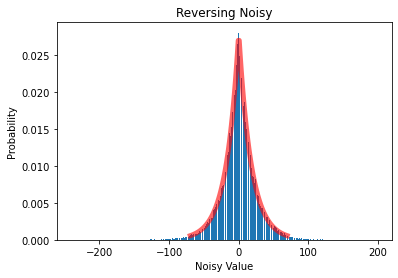

In [ ]:
def reverseNoise(noisyCount, OGCount, T, eps): 
    #The real noise 
    scale = ((1+math.log2(T))/eps)
    x = np.linspace(laplace.ppf(0.01, loc = 0, scale = scale ), laplace.ppf(0.99, loc = 0, scale = scale), 100)
    plt.plot(x, laplace.pdf(x, loc= 0, scale = scale),'r-', lw=5, alpha=0.6, label='laplace pdf')
    
    #Reversing noise
    noiseVec = np.subtract(noisyCount,OGCount)
    c = Counter(noiseVec) 
    c = {k: v / total for total in (sum(c.values()),) for k, v in c.items()}
    plt.bar(c.keys(), c.values())
    
    np.linspace(min(c.values()), max(c.values()))
    plt.title("Reversing Noisy")
    plt.xlabel("Noisy Value")
    plt.ylabel("Probability")
    plt.show()
    return c

T = 2**15
data = dataCreator(T)
eps = 0.9
originalTree, noisyTree = counterAlgorithm(data, eps) #[[root], [root.left, root,right], ....] 
OGInterval, OGvalue = getIntervalAndValues(originalTree)
NoisyInterval, Noisyvalue = getIntervalAndValues(noisyTree)
counterDict = reverseNoise(OGvalue,Noisyvalue, T, eps)


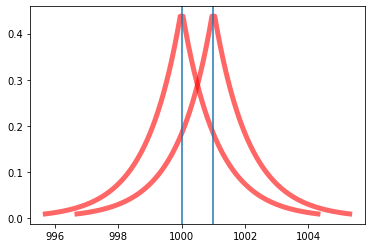

In [ ]:
scale = math.log(3)
x = np.linspace(laplace.ppf(0.01, loc = 0, scale = scale), laplace.ppf(0.99, loc = 0, scale = scale), 100)
plt.plot(x+1000, laplace.pdf(x, loc= 0, scale = scale),'r-', lw=5, alpha=0.6, label='laplace pdf')
plt.plot(x+1001, laplace.pdf(x, loc= 0, scale = scale),'r-', lw=5, alpha=0.6, label='laplace pdf')
plt.axvline(x = 1000)
plt.axvline(x = 1001)

